[Source 1](https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/)

[Source 2](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
#plt.style.use('seaborn-paper')
#print(plt.style.available)
#plt.style.use('seaborn')
#plt.style.use('ggplot')
import itertools
import warnings
import statsmodels.api as sm
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times New Roman",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams.update({'font.size': 12})
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
rc('text', usetex=True)
from sklearn.metrics import mean_squared_error, r2_score


In [21]:
# Parameter Selection for the ARIMA Time Series Model

def optimize_hyperparameters_sarima(y):

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    #print('Examples of parameter combinations for Seasonal ARIMA...')
    #print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
    #print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
    #print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
    #print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))
    #print('')
    p = np.arange(100000)
    d = np.arange(100000)
    q = np.arange(100000)
    S1 = np.arange(100000)
    S2 = np.arange(100000)
    S3 = np.arange(100000)
    S4 = np.arange(100000)
    AIC = np.arange(100000)
    warnings.filterwarnings("ignore")  # specify to ignore warning messages
    warnings.simplefilter("ignore")
    k=0
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                p[k] = param[0]
                d[k] = param[1]
                q[k] = param[2]
                S1[k] = param_seasonal[0]
                S2[k] = param_seasonal[1]
                S3[k] = param_seasonal[2]
                S4[k] = param_seasonal[3]
                AIC[k] = results.aic
                k+=1
            except:
                continue
    p = p[0:k]
    d = d[0:k]
    q = q[0:k]
    S1 = S1[0:k]
    S2 = S2[0:k]
    S3 = S3[0:k]
    S4 = S4[0:k]
    AIC = AIC[0:k]
    df = pd.DataFrame({'p':p,'d':d,'q':q,'S1':S1,'S2':S2,'S3':S3,'S4':S4,'AIC':AIC}).sort_values(by="AIC",ascending=True)
    df = df.reset_index(drop=True)
    print('BEST:')
    print('ARIMA{}x{} - AIC:{}'.format((df.p[0],df.d[0],df.q[0]), (df.S1[0],df.S2[0],df.S3[0],df.S4[0]), df.AIC[0]))
    print('OTHERS:')
    print(df.head(10))

In [22]:
%pwd

'/Users/joseangelvelasco/GoogleDrive/thesis/timeseries'

In [17]:
%cd ..

/Users/joseangelvelasco/GoogleDrive/thesis/timeseries


# Weather data

In [23]:
df0 = pd.read_csv('data/weather_data.csv',sep=',') # 1-min resolution
df0['timestamp'] = df0.index
df0['timestamp'] = pd.to_datetime(df0['timestamp'])
df0.reset_index(drop=True, inplace=True)

if df0.isna().sum().sum()>0:
    df0 = df0.fillna(df0.bfill())
    
df0.head()

,Global Horizontal [W/m^2],Direct Normal [W/m^2],Air Temperature [deg C],timestamp
0,0.139223,0.0,5.447,2015-01-01 00:01:00
1,0.324855,0.0,5.507,2015-01-01 00:02:00
2,0.417672,0.0,5.517,2015-01-01 00:03:00
3,0.185633,0.0,5.432,2015-01-01 00:04:00
4,0.139225,0.0,5.366,2015-01-01 00:05:00


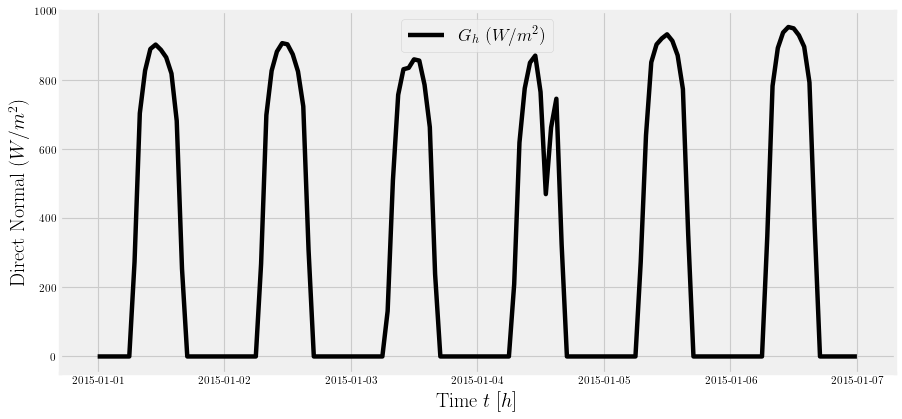

In [6]:
ts2 = df0.set_index('timestamp')['Direct Normal [W/m^2]']
ts2 = ts2.resample('H').mean()
ts2.head()


start_date = '2015-01-01 00:00:00'
end_date   = '2015-01-07 00:00:00'
date       = '2015-01-03 00:00:00'
y2 = ts2[start_date:end_date]

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y2,'k-')
plt.ylabel('Direct Normal $(W/m^2)$', fontsize=18)
plt.xlabel('Time $t$ $ [h]$', fontsize=18)
plt.legend(('$G_h$ $(W/m^2)$',), fontsize=16)

plt.savefig('figures/fig_3_direct_normal.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()

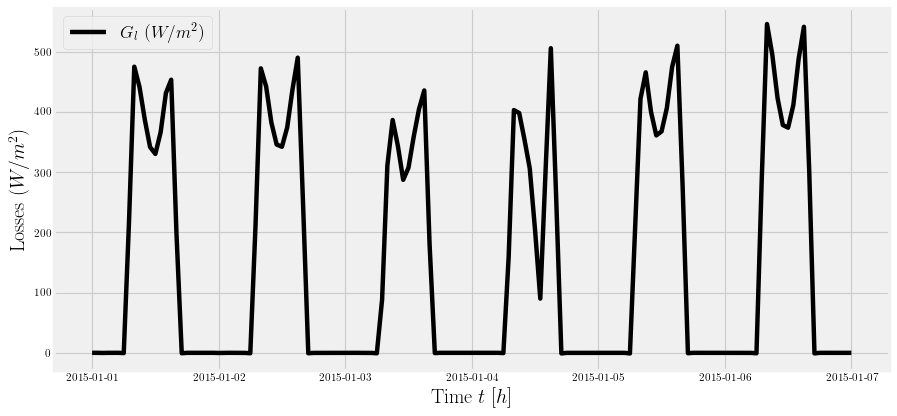

In [7]:
df0['losses'] = df0['Direct Normal [W/m^2]'] - df0['Global Horizontal [W/m^2]']  

ts4 = df0.set_index('timestamp')['losses']
ts4 = ts4.resample('H').mean()
ts4.head()


start_date = '2015-01-01 00:00:00'
end_date   = '2015-01-07 00:00:00'
date       = '2015-01-03 00:00:00'
y4 = ts4[start_date:end_date]

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y4,'k-')
plt.ylabel('Losses $(W/m^2)$', fontsize=18)
plt.xlabel('Time $t$ $ [h]$', fontsize=18)
plt.legend(('$G_l$ $(W/m^2)$',), fontsize=16)

plt.savefig('figures/fig_4_lossses.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()

# Temperature

In [27]:
%ls

data/      figures/   notebooks/


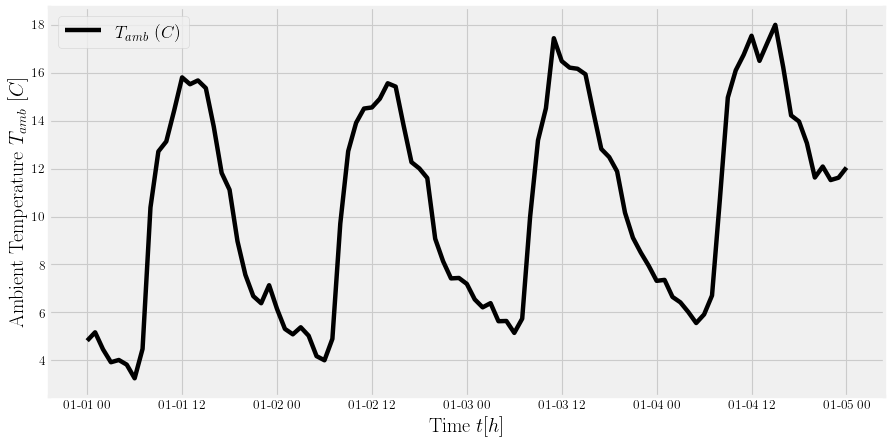

In [28]:
start_date = '2015-01-01 00:00:00'
end_date   = '2015-01-05 00:00:00'
date       = '2015-01-03 00:00:00'

ts = df0.set_index('timestamp')['Air Temperature [deg C]']
ts = ts.resample('H').mean()
ts.head()
ts.tail()

#print(len(ts))
#print(type(ts))

y1 = ts[start_date:end_date]

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y1,'k-')
plt.ylabel('Ambient Temperature $T_{amb}$ $[ºC]$', fontsize=18)
plt.xlabel('Time $t [h]$', fontsize=18)
plt.legend(('$T_{amb}$ $(C)$',), fontsize=16)

plt.savefig('figures/fig_1_temperature_data.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()



In [29]:
optimize_hyperparameters_sarima(y1)

BEST:
ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:155
OTHERS:
   p  d  q  S1  S2  S3  S4  AIC
0  0  1  1   1   1   1  12  155
1  1  1  1   1   1   1  12  156
2  1  1  1   1   1   0  12  158
3  1  0  1   1   1   1  12  158
4  1  1  0   1   1   1  12  159
5  0  1  0   1   1   1  12  160
6  1  1  0   1   1   0  12  160
7  0  1  1   1   1   0  12  162
8  1  0  0   1   1   1  12  164
9  1  0  0   1   1   0  12  164


In [30]:
# Fitting an ARIMA Time Series Model
mod = sm.tsa.statespace.SARIMAX(y1,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3611      0.116     -3.110      0.002      -0.589      -0.134
ar.S.L12      -0.9255      0.031    -29.815      0.000      -0.986      -0.865
ma.S.L12      -0.4061      0.147     -2.760      0.006      -0.694      -0.118
sigma2         0.4715      0.073      6.502      0.000       0.329       0.614


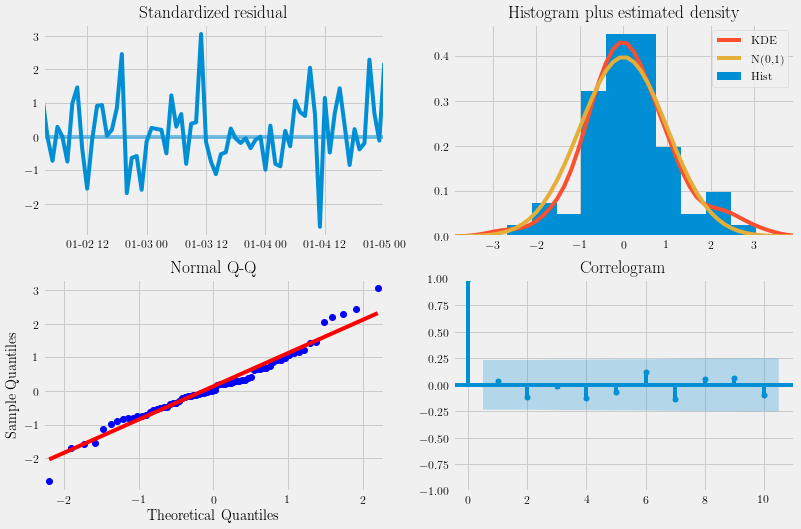

In [31]:
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(12, 8))
plt.savefig('figures/fig_temperature_arima_model.png',format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()

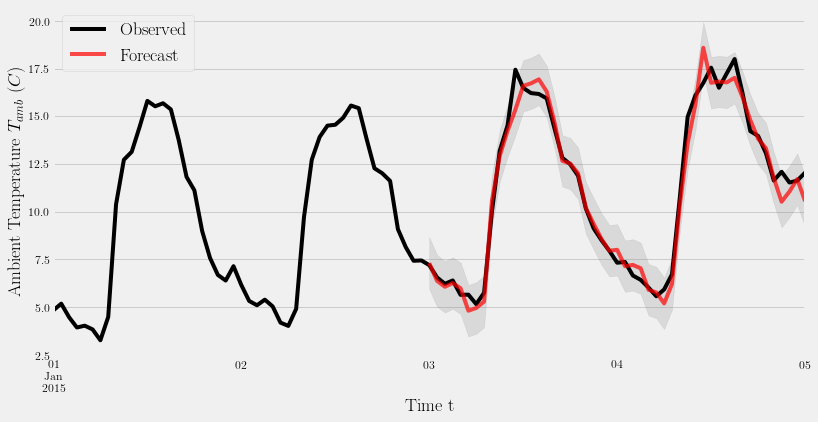

The Mean Squared Error of our forecasts is 0.4566


In [32]:
# Validating forecast
pred = results.get_prediction(start=pd.to_datetime(date), dynamic=False)
pred_ci = pred.conf_int()

ax = y1['2015':].plot(color='black',label='observed', figsize=(12, 6))
pred.predicted_mean.plot(color='red',ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
ax.set_ylabel('Ambient Temperature $T_{amb}$ $(ºC)$', fontsize=18)
plt.xlabel('Time t', fontsize=18)
plt.legend(('Observed','Forecast'),fontsize=18)
plt.savefig('figures/fig_3_temperature_training.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Compute the mean square error
y_forecasted = pred.predicted_mean
y_truth = y1[date:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))




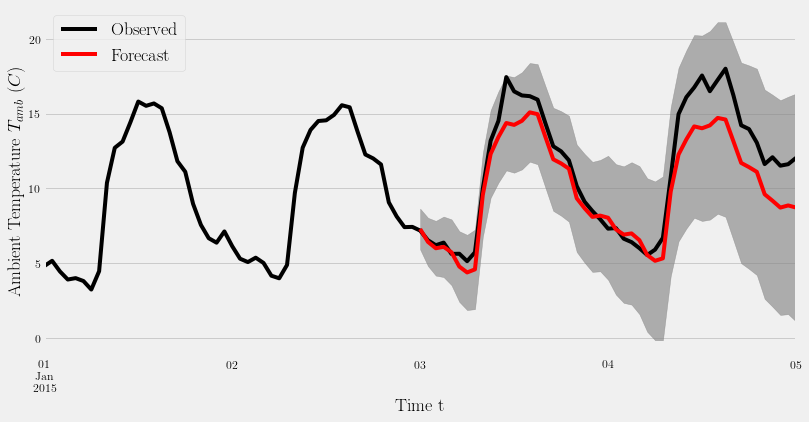

The Mean Squared Error of our forecasts is 3.16 (Dynamic)


In [33]:
# Validating forecast dynamic
pred_dynamic = results.get_prediction(start=pd.to_datetime(date), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ax = y1['2013':].plot(color='black',label='observed', figsize=(12, 6))
pred_dynamic.predicted_mean.plot(color='red',label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='gray', alpha=.6)
#ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(date), y.index[-1],
#                 alpha=.1, zorder=-1)
ax.set_ylabel('Ambient Temperature $T_{amb}$ $(ºC)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed','Forecast'),fontsize=18)
plt.savefig('figures/fig_4_temperature_training_dynamic.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()

# Compute the mean square error
y_forecasted = pred_dynamic.predicted_mean
y_truth = y1[date:]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {} (Dynamic)'.format(round(mse, 2)))

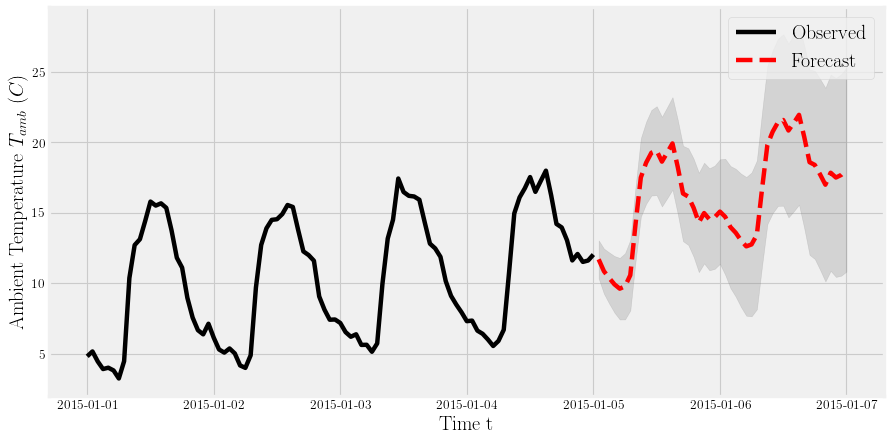

In [34]:
# Forecast one day ahead
pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int() # confidence intervals

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y1,'k-',label='observed')
ax.plot(pred_uc.predicted_mean,'r--',label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.25)
ax.set_ylabel('Ambient Temperature $T_{amb}$ $(ºC)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed','Forecast'),fontsize=18)
plt.savefig('figures/fig_5_temperature_forecast.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()

In [35]:
T_hat = pred_uc.predicted_mean
T_obs = y1
T_ucl = pred_ci.iloc[:, 0]
T_lcl = pred_ci.iloc[:, 1]
df_temperature_results = pd.DataFrame({'T_hat':T_hat,'T_obs':T_obs,'T_ucl':T_ucl,'T_lcl':T_lcl})
df_temperature_results['timestamp'] = df_temperature_results.index
df_temperature_results.fillna(0, inplace=True)
df_temperature_results.reset_index(inplace=True, drop=True)
df_temperature_results.to_csv("data/results_forecast_temperature.csv", index=False)
df_temperature_results.tail()

,T_hat,T_obs,T_ucl,T_lcl,timestamp
140,17.002418,0.0,10.134139,23.870697,2015-01-06 20:00:00
141,17.851808,0.0,10.889044,24.814571,2015-01-06 21:00:00
142,17.510717,0.0,10.454734,24.566700,2015-01-06 22:00:00
143,17.694031,0.0,10.546044,24.842017,2015-01-06 23:00:00
144,18.077757,0.0,10.838936,25.316578,2015-01-07 00:00:00


# Irradiance

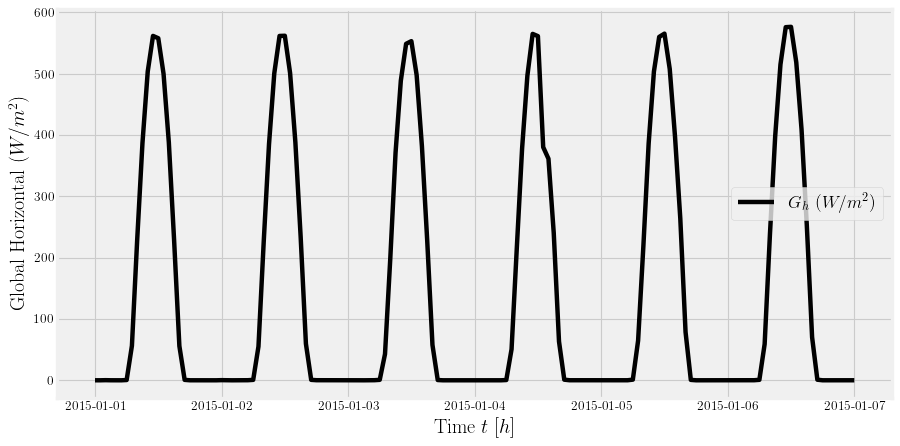

In [36]:
ts3 = df0.set_index('timestamp')['Global Horizontal [W/m^2]']
ts3 = ts3.resample('H').mean()
ts3.head()


start_date = '2015-01-01 00:00:00'
end_date   = '2015-01-07 00:00:00'
date       = '2015-01-03 00:00:00'
y3 = ts3[start_date:end_date]

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y3,'k-')
plt.ylabel('Global Horizontal $(W/m^2)$', fontsize=18)
plt.xlabel('Time $t$ $ [h]$', fontsize=18)
plt.legend(('$G_h$ $(W/m^2)$',), fontsize=16)

plt.savefig('figures/fig_2_global_irradiance.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()
#plt.close()

In [37]:
optimize_hyperparameters_sarima(y3)

BEST:
ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:1016
OTHERS:
   p  d  q  S1  S2  S3  S4   AIC
0  1  1  1   1   1   1  12  1016
1  0  0  1   1   1   1  12  1019
2  1  0  1   1   1   1  12  1020
3  1  1  1   1   1   0  12  1022
4  1  0  0   1   1   0  12  1024
5  1  0  0   1   1   1  12  1026
6  1  0  1   1   1   0  12  1027
7  0  0  1   1   1   0  12  1031
8  0  0  0   1   1   1  12  1034
9  0  0  0   1   1   0  12  1039


In [39]:
# Fitting an ARIMA Time Series Model
mod = sm.tsa.statespace.SARIMAX(y3,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2651      0.185      1.435      0.151      -0.097       0.627
ma.L1         -1.0222      0.096    -10.607      0.000      -1.211      -0.833
ar.S.L12      -1.0016      0.011    -88.181      0.000      -1.024      -0.979
ma.S.L12      -0.0140      1.765     -0.008      0.994      -3.474       3.446
sigma2       279.6135     48.464      5.769      0.000     184.625     374.602


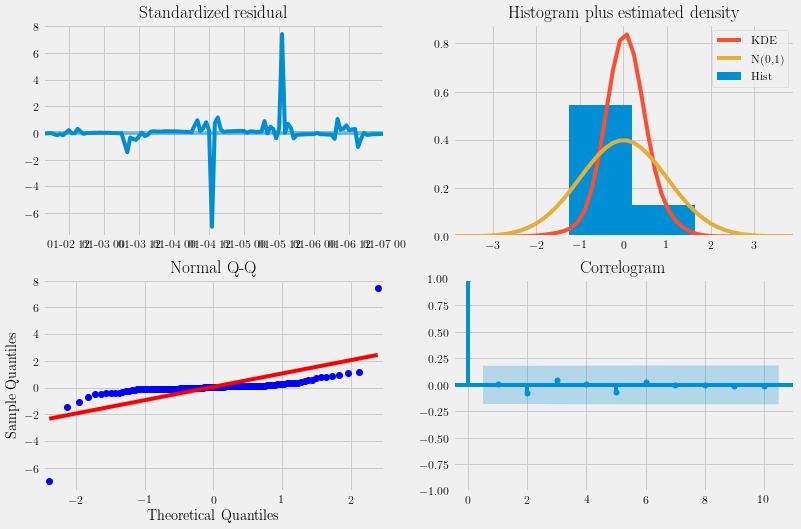

In [40]:
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(12, 8))
plt.show()
#plt.close()

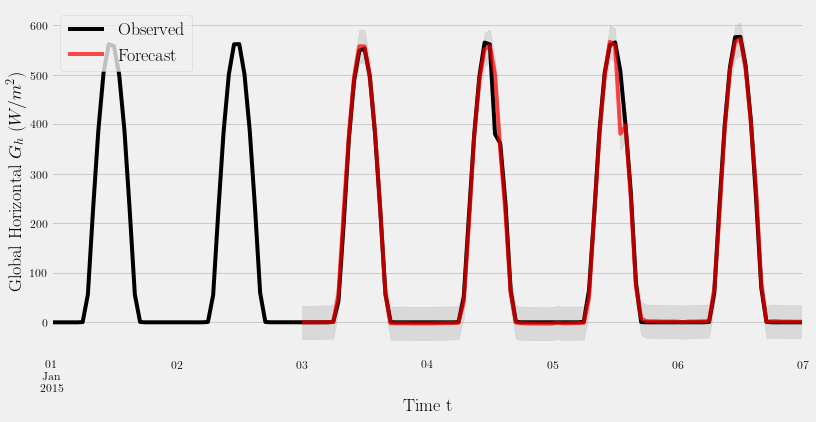

MSE:59537.562
R2:-0.395


In [41]:
# Validating forecast
pred = results.get_prediction(start=pd.to_datetime(date), dynamic=False)
pred_ci = pred.conf_int()

ax = y3['2015':].plot(color='black',label='observed', figsize=(12, 6))
pred.predicted_mean.plot(color='red',ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
ax.set_ylabel('Global Horizontal  $G_h$ $(W/m^2)$', fontsize=18)
plt.xlabel('Time t', fontsize=18)
plt.legend(('Observed','Forecast'),fontsize=18)
plt.show()

# Compute the mean square error
y_forecasted = pred.predicted_mean
y_truth = y1[date:]
mse = ((y_forecasted - y_truth) ** 2).mean()

MSE = mean_squared_error(y_forecasted[-(24*2):], y_truth[-(24*2):])
print('MSE:{}'.format(round(MSE, 4)))

R2 = r2_score(y_forecasted[-(24*2):], y_truth[-(24*2):])

print('R2:{}'.format(round(R2, 3)))

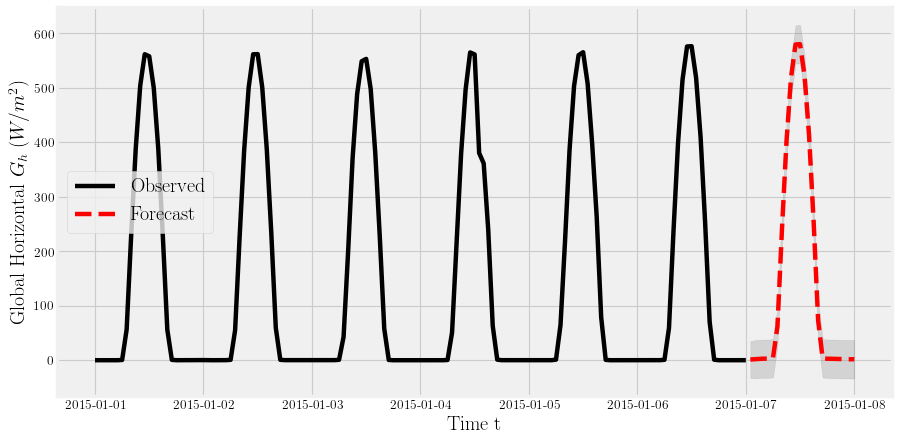

In [42]:
# Forecast one day ahead
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int() # confidence intervals

fig = plt.figure(num=None, figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y3,'k-',label='observed')
ax.plot(pred_uc.predicted_mean,'r--',label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.25)
ax.set_ylabel('Global Horizontal  $G_h$ $(W/m^2)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed','Forecast'),fontsize=18)
plt.show()
#plt.close()

In [44]:
G_hat = pred_uc.predicted_mean
G_obs = y3
G_ucl = pred_ci.iloc[:, 0]
G_lcl = pred_ci.iloc[:, 1]
df_irradiance_results = pd.DataFrame({'G_hat': G_hat, 'G_obs': G_obs, 'G_ucl': G_ucl, 'G_lcl': G_lcl})
df_irradiance_results['timestamp'] = df_irradiance_results.index
df_irradiance_results.fillna(0, inplace=True)
df_irradiance_results.reset_index(inplace=True, drop=True)
df_irradiance_results.to_csv("data/results_forecast_irradiance.csv", index=False)

# REE data

In [ ]:
#%pwd

In [ ]:
#%cd ..

In [45]:
df = pd.read_csv('data/REE_profiles.csv')
date = []
for k in range(0,len(df)):
    date.append(pd.Timestamp(int(df.date[k][0:4]), int(df.date[k][5:7]), int(df.date[k][8:10]), int(df.date[k][11:13]))) 
df = df.drop(['date','season'],axis=1)
df['date'] = date
df = df.set_index('date')
df['coef_a'] = (df['coef_a'] - df['coef_a'].min()) /(df['coef_a'].max() - df['coef_a'].min()) 
df['coef_b'] = (df['coef_b'] - df['coef_b'].min()) /(df['coef_b'].max() - df['coef_b'].min()) 
df['coef_c'] = (df['coef_c'] - df['coef_c'].min()) /(df['coef_c'].max() - df['coef_c'].min()) 
df['coef_d'] = (df['coef_d'] - df['coef_d'].min()) /(df['coef_d'].max() - df['coef_d'].min()) 
df.head()

,coef_a,coef_b,coef_c,coef_d
date,,,,
2013-01-01 00:00:00,0.481664,0.645639,0.065478,0.119835
2013-01-01 01:00:00,0.395631,0.593000,0.071795,0.706145
2013-01-01 02:00:00,0.265599,0.533667,0.070292,0.615586
2013-01-01 03:00:00,0.162789,0.484855,0.065936,0.360136
2013-01-01 04:00:00,0.119022,0.450538,0.063806,0.148254


In [46]:
df['coef_a'].describe()

count    51120.000000
mean         0.361783
std          0.174267
min          0.000000
25%          0.207405
50%          0.377542
75%          0.485191
max          1.000000
Name: coef_a, dtype: float64

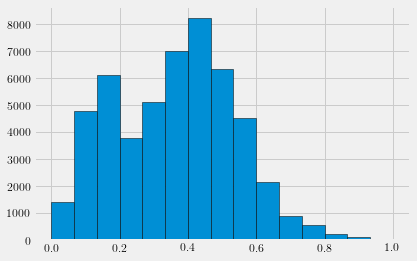

In [50]:
plt.hist(df['coef_a'], histtype='barstacked', edgecolor='black', bins=15)
plt.show()

In [51]:
df.tail(3)

,coef_a,coef_b,coef_c,coef_d
date,,,,
2018-10-31 21:00:00,0.564798,0.276736,0.336889,0.411450
2018-10-31 22:00:00,0.460938,0.264345,0.267740,0.407352
2018-10-31 23:00:00,0.339225,0.253545,0.221618,0.372568


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51120 entries, 2013-01-01 00:00:00 to 2018-10-31 23:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   coef_a  51120 non-null  float64
 1   coef_b  51120 non-null  float64
 2   coef_c  51120 non-null  float64
 3   coef_d  51120 non-null  float64
dtypes: float64(4)
memory usage: 2.0 MB


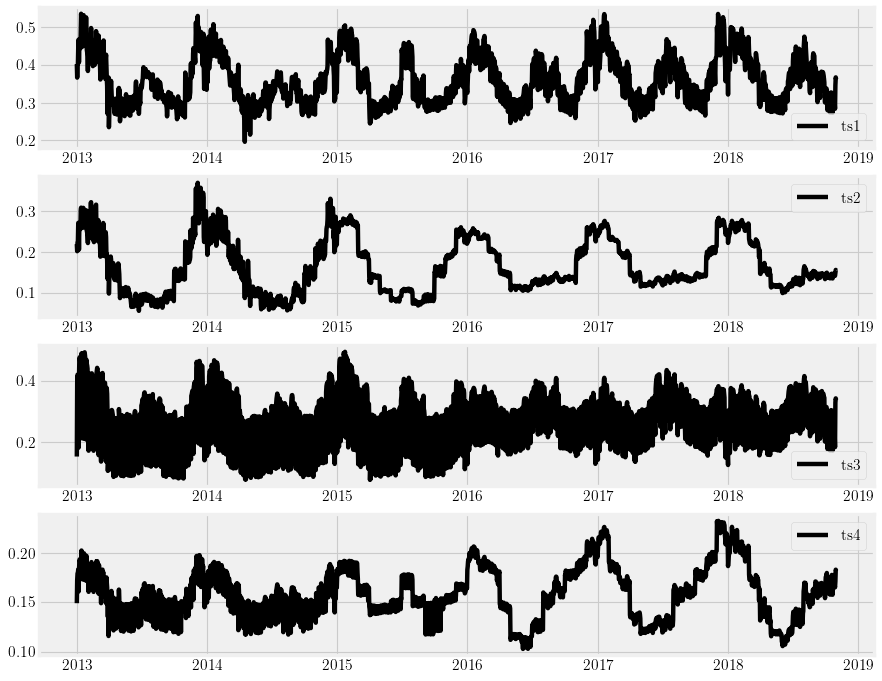

In [53]:
fig = plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')


ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(df.resample('D').mean()['coef_a'],'k')
ax1.legend(('ts1',),fontsize=14)
ax1.tick_params(axis='both', labelsize=14)

ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(df.resample('D').mean()['coef_b'],'k')
ax2.legend(('ts2',),fontsize=14)
ax2.tick_params(axis='both', labelsize=14)


ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(df.resample('D').mean()['coef_c'],'k')
ax3.legend(('ts3',),fontsize=14)
ax3.tick_params(axis='both', labelsize=14)


ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(df.resample('D').mean()['coef_d'],'k')
ax4.legend(('ts4',),fontsize=14)
ax4.tick_params(axis='both', labelsize=14)



plt.savefig('figures/fig_REE_timeseries.png', format='png', bbox_inches='tight', pad_inches=0.1)
plt.show()

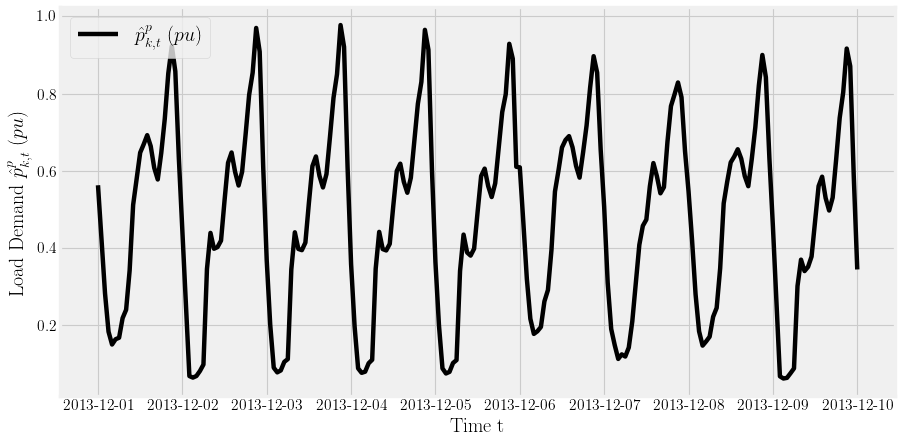

In [54]:
start_date = '2013-12-01 00:00:00'
end_date = '2013-12-10 00:00:00'
date = '2013-12-03 00:00:00'
ts = df.resample('H').mean()['coef_a']
y = ts[start_date:end_date]

fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.tick_params(axis='both', labelsize=14)
ax.plot(y, 'k-')
plt.ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
plt.xlabel('Time t', fontsize=18)
plt.legend(('$\hat{p}^p_{k,t}$ $(pu)$',), fontsize=18)
#plt.savefig('fig_demand_1_data.eps')
plt.show()

In [55]:
optimize_hyperparameters_sarima(y)

BEST:
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:-645
OTHERS:
   p  d  q  S1  S2  S3  S4  AIC
0  1  0  1   1   1   0  12 -645
1  1  0  1   1   1   1  12 -643
2  0  1  1   1   1   0  12 -612
3  1  1  1   1   1   0  12 -608
4  0  1  1   1   1   1  12 -605
5  1  1  1   1   1   1  12 -603
6  1  0  0   1   1   0  12 -600
7  1  0  0   1   1   1  12 -598
8  1  1  0   1   1   1  12 -595
9  1  1  0   1   1   0  12 -592


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6464      0.054     11.913      0.000       0.540       0.753
ma.L1          0.5399      0.067      8.031      0.000       0.408       0.672
ar.S.L12      -0.9586      0.029    -32.560      0.000      -1.016      -0.901
sigma2         0.0019      0.000     15.870      0.000       0.002       0.002


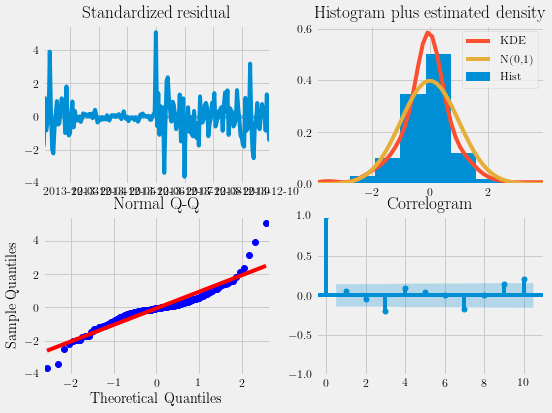

In [56]:
# Fitting an SARIMA Time Series Model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(8, 6))
plt.show()

In [ ]:
# Validating forecast
pred = results.get_prediction(start=pd.to_datetime(date), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2013':].plot(color='black', label='observed', figsize=(12, 6))
pred.predicted_mean.plot(color='red', ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
plt.xlabel('Time t', fontsize=18)
plt.legend(('Observed', 'Forecast'), fontsize=18)
plt.show()


# Compute the mean square error
y_forecasted = pred.predicted_mean
y_truth = y[date:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE:{}'.format(round(mse, 3)))

R2 = round(r2_score(y_forecasted[-48:], y_truth[-48:]),3)
print('R2:{}'.format(R2))

In [ ]:
# Validating forecast dynamic
pred_dynamic = results.get_prediction(start=pd.to_datetime(date), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ax = y['2013':].plot(color='black', label='observed', figsize=(12, 6))
pred_dynamic.predicted_mean.plot(color='red', label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='gray', alpha=.6)
# ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(date), y.index[-1],
#                 alpha=.1, zorder=-1)
ax.set_ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed', 'Forecast'), fontsize=18)
plt.show()

# Compute the mean square error
y_forecasted = pred_dynamic.predicted_mean
y_truth = y[date:]
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE:{}'.format(round(mse, 3)))
R2 = round(r2_score(y_forecasted[-48:], y_truth[-48:]),3)
print('R2:{}'.format(R2))

In [ ]:
# Forecast one day ahead
pred_uc = results.get_forecast(steps=24*3)
pred_ci = pred_uc.conf_int()  # confidence intervals

fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y, 'k-', label='observed')
ax.plot(pred_uc.predicted_mean, 'r', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.4)
ax.set_ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed', 'Forecast'), fontsize=18)
plt.show()


In [ ]:
Pd_hat = pred_uc.predicted_mean
Pd_obs = y
Pd_ucl = pred_ci.iloc[:, 0]
Pd_lcl = pred_ci.iloc[:, 1]
df_demand_results = pd.DataFrame({'Pd_hat': Pd_hat, 'Pd_obs': Pd_obs, 'Pd_ucl': Pd_ucl, 'Pd_lcl': Pd_lcl})
df_demand_results['timestamp'] = df_demand_results.index
df_demand_results.fillna(0, inplace=True)
df_demand_results.reset_index(inplace=True, drop=True)
df_demand_results.to_csv("data/results_forecast_demand.csv", index=False)
df_demand_results.tail()

# Load demand 

In [ ]:
%cd ..

In [ ]:
df = pd.read_csv('data/data_loads_dem_original_pyomo.csv')

In [ ]:
df.head()

In [ ]:
# Create time series
Pdem1 = np.zeros(70000)
k = 0
for t in df.data_time.unique():
    Pdem1[k] = df[df.data_time == t].PDem.sum()
    k += 1
Pdem1 = Pdem1[0:k]
Pdem2 = np.multiply(Pdem1, 1.02)
Pdem3 = np.multiply(Pdem1, 1.04)
Pdem4 = np.multiply(Pdem1, 1.06)
Pdem = np.concatenate((Pdem1, Pdem2, Pdem3, Pdem4), axis=0)
start_date = '2013-01-01 00:00:00'
end_date = '2013-01-05 00:00:00'
dates = pd.date_range(start_date, end_date, freq='10min')
dates = dates[0:len(dates) - 1]
df = pd.DataFrame({'Pdem': Pdem, 'dates': dates})
df = df.set_index('dates')
# y = df.Pdem
y = df.Pdem.resample('H').mean()

In [ ]:
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y, 'k-')
ax.tick_params(axis='both', labelsize=14)
ax.set_ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.show()

In [ ]:
 optimize_hyperparameters_sarima(y)

In [ ]:
# Fitting an ARIMA Time Series Model
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(8, 6))
plt.show()

In [ ]:
# Validating forecast
date = '2013-01-04 00:00:00'
pred = results.get_prediction(start=pd.to_datetime(date), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2013':].plot(color='black', label='observed', figsize=(12, 6))
pred.predicted_mean.plot(color='red', ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.legend(('Observed', 'Forecast'), fontsize=18)
plt.show()

In [ ]:
# Validating forecast dynamic
date = '2013-01-04 00:00:00'
pred_dynamic = results.get_prediction(start=pd.to_datetime(date), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()
ax = y['2013':].plot(color='black', label='observed', figsize=(12, 6))
pred_dynamic.predicted_mean.plot(color='red', label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='gray', alpha=.6)
# ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(date), y.index[-1],
#                 alpha=.1, zorder=-1)
ax.set_ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed', 'Forecast'), fontsize=18)
plt.show()

In [ ]:
# Forecast one day ahead
pred_uc = results.get_forecast(steps=24)
pred_ci = pred_uc.conf_int()  # confidence intervals
fig = plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 1, 1)
ax.plot(y, 'k-', label='observed')
ax.plot(pred_uc.predicted_mean, 'r', label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='gray', alpha=.2)
ax.set_ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=18)
ax.set_xlabel('Time t', fontsize=18)
plt.legend(('Observed', 'Forecast'), fontsize=18)
plt.show()

In [ ]:
Pd_hat = pred_uc.predicted_mean
Pd_obs = y
Pd_ucl = pred_ci.iloc[:, 0]
Pd_lcl = pred_ci.iloc[:, 1]
df_demand_results = pd.DataFrame({'Pd_hat': Pd_hat, 'Pd_obs': Pd_obs, 'Pd_ucl': Pd_ucl, 'Pd_lcl': Pd_lcl})
df_demand_results.fillna(0, inplace=True)
df_demand_results.to_csv("data/results_forecast_demand_val.csv")

# Results

In [3]:
%cd ..

/Users/joseangelvelasco/GoogleDrive/thesis/timeseries/forecasting


In [64]:
df = pd.read_csv('data/results_forecast_demand.csv')
df.set_index(['timestamp'], inplace=True)

df1 = pd.read_csv('data/results_forecast_irradiance.csv')
df1.set_index(['timestamp'], inplace=True)

df2 = pd.read_csv('data/results_forecast_temperature.csv')
df2.set_index(['timestamp'], inplace=True)

In [65]:
df_aux = df['2013-12-08':'2013-12-12']
df_aux1 = df1['2015-01-03':'2015-01-07']
df_aux2 = df2['2015-01-03':'2015-01-07']

In [66]:
df_aux1.head()

,Unnamed: 0,G_hat,G_obs,G_ucl,G_lcl
timestamp,,,,,


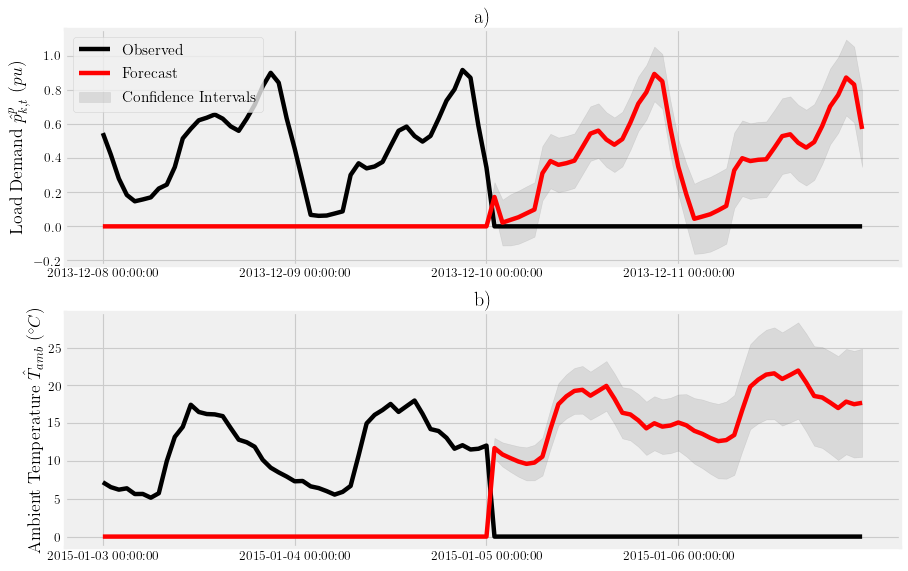

In [62]:
fig = plt.figure(num=None, figsize=(12,8), dpi=80, facecolor='w', edgecolor='k')

ax = fig.add_subplot(2, 1, 1)
ax.plot(df_aux.loc[:,'Pd_obs'].index, df_aux.loc[:, 'Pd_obs'].values,'k-')
ax.plot(df_aux.loc[:,'Pd_hat'].index, df_aux.loc[:, 'Pd_hat'].values,'r-')
ax.fill_between(df_aux.loc[:,'Pd_ucl'].index,
                df_aux.loc[:, 'Pd_ucl'].values,
                df_aux.loc[:, 'Pd_lcl'].values, color='gray', alpha=.2)
plt.xticks(np.arange(0,24*4,24), fontsize=10)
#plt.xticks(np.arange(0,24*4,24),['2018-04-26','2018-04-27','2018-04-28','2018-04-29','2018-04-30'], fontsize=10)
plt.title('a)', fontsize=18)
ax.set_ylabel('Load Demand $\hat{p}^p_{k,t}$ $(pu)$', fontsize=16)
#ax.set_xlabel('Time t', fontsize=16)
plt.legend(('Observed','Forecast','Confidence Intervals',), fontsize=14, loc='best')
ax.tick_params(axis='both', labelsize=12)


ax = fig.add_subplot(2, 1, 2)
ax.plot(df_aux2.loc[:,'T_obs'].index, df_aux2.loc[:, 'T_obs'].values,'k-')
ax.plot(df_aux2.loc[:,'T_hat'].index, df_aux2.loc[:, 'T_hat'].values,'r-')
ax.fill_between(df_aux2.loc[:, 'T_ucl'].index,
                df_aux2.loc[:, 'T_ucl'].values,
                df_aux2.loc[:, 'T_lcl'].values, color='gray', alpha=.2)
plt.xticks(np.arange(0,24*4,24), fontsize=10)
plt.title('b)', fontsize=18)
ax.set_ylabel('Solar Irradiance $\hat{G}_t$ $(W/m^2)$', fontsize=18)
#ax.set_xlabel('Time t', fontsize=16)
#plt.legend(('Observed','Forecast','Confidence Intervals',), fontsize=14, loc='best')
ax.tick_params(axis='both', labelsize=12)

if 1 == 0:
    ax = fig.add_subplot(3, 1, 3)
    ax.plot(df1.loc[:,'G_obs'].dropna().index, df1.loc[:, 'G_obs'].dropna().get_values(),'k-')
    ax.plot(df1.loc[:,'G_hat'].dropna().index, df1.loc[:, 'G_hat'].dropna().get_values(),'r-')
    ax.fill_between(df1.loc[:,'G_ucl'].dropna().index,
                    df1.loc[:, 'G_ucl'].dropna().get_values(),
                    df1.loc[:, 'G_lcl'].dropna().get_values(), color='gray', alpha=.2)
    plt.xticks(np.arange(0,24*6,24),['2018-04-26','2018-04-27','2018-04-28','2018-04-29','2018-04-30'], fontsize=10)
    plt.title('c)', fontsize=18)
    ax.set_ylabel('Ambient Temperature $\hat{T}_{amb}$ $(^\circ C)$', fontsize=16)
    #plt.ylabel('Solar Irradiance $\hat{G}_t$ $(W/m^2)$', fontsize=18)
    ax.set_xlabel('Time', fontsize=16)
    #plt.legend(('Observed','Forecast','Confidence Intervals',), fontsize=14, loc='best')
    ax.tick_params(axis='both', labelsize=12)

#plt.savefig('fig_forecast.pdf')
plt.show()
#plt.close()

In [ ]:
df = pd.read_csv('results_forecast_demand_val.csv')
df = df.rename(index=str, columns={"Unnamed: 0": "date"})
df = df.set_index('date')
df = np.multiply(df,1/800000)

df1 = pd.read_csv('results_forecast_irradiance.csv')
df1 = df1.rename(index=str, columns={"Unnamed: 0": "date"})
df1 = df1.set_index('date')
df1  = np.multiply(df1,1/(0.015*800000))

df3 = pd.read_csv('results_forecast_temperature.csv')
df3 = df3.rename(index=str, columns={"Unnamed: 0": "date"})
df3 = df3.set_index('date')

fig = plt.figure(num=None, figsize=(16,12), dpi=120, facecolor='w', edgecolor='k')

ax = fig.add_subplot(2, 1, 1)
ax.plot(df.loc[:,'Pd_obs'].dropna().index, df.loc[:, 'Pd_obs'].dropna().get_values(),'k-')
ax.plot(df.loc[:,'Pd_hat'].dropna().index, df.loc[:, 'Pd_hat'].dropna().get_values(),'r-')
ax.fill_between(df.loc[:,'Pd_ucl'].dropna().index,
                df.loc[:, 'Pd_ucl'].dropna().get_values(),
                df.loc[:, 'Pd_lcl'].dropna().get_values(), color='gray', alpha=.2)
plt.xticks(np.arange(0,24*6,24),['2018-04-26','2018-04-27','2018-04-28','2018-04-29','2018-04-30'], fontsize=10)
plt.title('a)', fontsize=18)
ax.set_ylabel('Load Demand $\sum_k \sum_p \hat{p}^{p}_{k,t} $ $(pu)$', fontsize=18)
#ax.set_xlabel('Time t', fontsize=16)
plt.legend(('Observed','Forecast','Confidence Intervals',), fontsize=16, loc='lower left')
ax.tick_params(axis='both', labelsize=18)

ax = fig.add_subplot(2, 1, 2)
ax.plot(df1.loc[:,'G_obs'].dropna().index, df1.loc[:, 'G_obs'].dropna().get_values(),'k-')
ax.plot(df1.loc[:,'G_hat'].dropna().index, df1.loc[:, 'G_hat'].dropna().get_values(),'r-')
ax.fill_between(df1.loc[:, 'G_ucl'].dropna().index,
                df1.loc[:, 'G_ucl'].dropna().get_values(),
                df1.loc[:, 'G_lcl'].dropna().get_values(), color='gray', alpha=.2)
plt.xticks(np.arange(0,24*6,24),['2018-04-26','2018-04-27','2018-04-28','2018-04-29','2018-04-30'], fontsize=10)
plt.title('b)', fontsize=18)
ax.set_ylabel('PV Generation $\sum_k \sum_p \hat{p}^{p}_{g,k,t}$ $(pu)$', fontsize=18)
#ax.set_xlabel('Time t', fontsize=16)
plt.legend(('Observed','Forecast','Confidence Intervals',), fontsize=16, loc='lower left')
ax.tick_params(axis='both', labelsize=18)


plt.savefig('fig_forecast_val.eps')
plt.show()
plt.close()